# Gradient Descent
**Author:** Magdalena Whelley

**Topic:** Supervised Learning - Optimization with Gradient Descent

## 1. Overview
Gradient Descent is an optimization algorithm used to minimize a cost function by iteratively adjusting model parameters in the direction of the negative gradient.
In this notebook, we apply gradient descent to a linear regression problem using real stock data (Apple Inc., AAPL) to predict next-day returns from recent market behavior.

In the original version of this notebook, the gradient descent algorithm was implemented directly inside the notebook.
After restructuring the project, the reusable algorithmic implementation now resides in the custom machine-learning package `rice_ml` (as `GradientDescentRegressor`).
The notebook now imports and uses that implementation, while still demonstrating all analysis, feature engineering, visualization, and evaluation steps.

This notebook will:
- Load and visualize financial data
- Create features representing recent return, volatility, and momentum
- Train a custom gradient-descent linear regressor from the `rice_ml` package
- Analyze convergence behavior
- Compare model performance with LinearRegression from `scikit-learn`

In [1]:
# 2. Setup
import numpy as np, pandas as pd, matplotlib.pyplot as plt, yfinance as yf, os
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from rice_ml import GradientDescentRegressor

## Why Gradient Descent?

The objective of gradient descent is to minimize the cost function, which measures how far the model's predictions are from the true values. 

For linear regression, the cost function is the **Mean Square Error (MSE)**:

$$
    J(\theta) = \frac{1}{m} \sum_{i=1}^m (y^{(i)} - \hat{y}^{(i)})^2
$$

We cannot solve this analytically for complex models, so we use gradient descent to iteratively update the parameters: 

$$
    \theta := \theta - \alpha \frac{\partial J}{\partial \theta}
$$

where **$\alpha$** is the learning rate.

This notebook uses the `GradientDescentRegressor` class implemented in my custom Python package `rice_ml`.
The package contains the reusable core algorithm, while this notebook focuses on data preparation, visualization, and analysis.

In [13]:
# 3. Load and Inspect Data

import os

data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")

if data is None or data.empty:
    raise ValueError("No data returned from Yahoo Finance.")

# Handle MultiIndex columns
if isinstance(data.columns, pd.MultiIndex):
    data = data.xs("AAPL", axis=1, level=1)

# Path to the central data directory
data_dir = "../../data"
os.makedirs(data_dir, exist_ok=True)

csv_path = os.path.join(data_dir, "AAPL_stock_data.csv")
data.to_csv(csv_path)

print(f"Saved data to: {csv_path}")

/var/folders/kl/9kxsb0qs21b5n113980ydgb80000gn/T/ipykernel_5304/3932349445.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2020-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed

Saved data to: ../../data/AAPL_stock_data.csv


## Feature Engineering

We will compute three indicators commonly used in financial modeling:

* **Daily Return:** fractional change in price  
* **5-Day Rolling Volatility:** recent standard deviation of returns  
* **Momentum:** relative change over 5 days  

These will serve as input features for our gradient descent regression model.

In [14]:
# 4. Feature Engineering

df = data.copy()

# Determine which price column to use — use 'Close' if 'Adj Close' isn’t available
price_col = "Adj Close" if "Adj Close" in df.columns else "Close"

# Compute features
df["Return"] = df[price_col].pct_change()
df["Volatility"] = df["Return"].rolling(5).std()
df["Momentum"] = df[price_col] / df[price_col].shift(5) - 1

# Drop NaN values created by rolling/shift operations
df.dropna(inplace=True)

# Create feature matrix (X) and target vector (y)
# We predict next-day return from today's features
X = df[["Return", "Volatility", "Momentum"]].values[:-1]
y = df["Return"].values[1:]

print(f"Using price column: {price_col}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Optional quick peek at processed data
df.head()

Using price column: Close
Feature matrix shape: (1251, 3)
Target vector shape: (1251,)


Price,Close,High,Low,Open,Volume,Return,Volatility,Momentum
Date,,,,,,,,
2020-01-09,74.707336,74.900357,73.879750,74.130675,170108400,0.021241,0.013224,0.030897
2020-01-10,74.876221,75.440821,74.374363,74.941371,140644800,0.002261,0.010409,0.043372
2020-01-13,76.475914,76.502459,75.074081,75.192313,121532000,0.021365,0.011841,0.057238
2020-01-14,75.443237,76.623097,75.320190,76.413185,161954400,-0.013503,0.015030,0.047890
2020-01-15,75.119919,76.123642,74.688027,75.242974,121923600,-0.004286,0.015547,0.026881


In [15]:
# 5. Normalize Features (mean = 0, std = 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add bias column (for intercept term)
X_b = np.c_[np.ones((X_scaled.shape[0], 1)), X_scaled]  # shape (N, 4)

print("Normalized feature matrix shape:", X_b.shape)

Normalized feature matrix shape: (1251, 4)


##Training the Model

We fit the `GradientDescentRegressor` on the normalized features.
The model internally handles the gradient computation, parameter updates, and optional cost tracking via the `store_cost` flag.

In [16]:
# 6. Train Gradient Descent Regressor using the package implementation

gd = GradientDescentRegressor(alpha=0.05, n_iter=300, fit_intercept=True, store_cost=True)
gd.fit(X_scaled, y)   # Note: X_scaled, not X_b (the class adds bias itself)

theta = gd.theta_                 # learned parameters
mse_history = gd.cost_history_    # list of costs per iteration
y_pred = gd.predict(X_scaled)

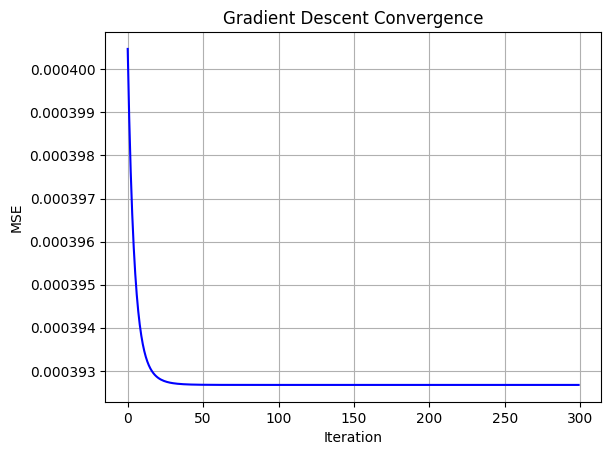

In [8]:
# 7. Convergence Plot
plt.figure()
n_iter = 300
plt.plot(range(n_iter), mse_history, color='blue')
plt.title("Gradient Descent Convergence")
plt.xlabel("Iteration")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

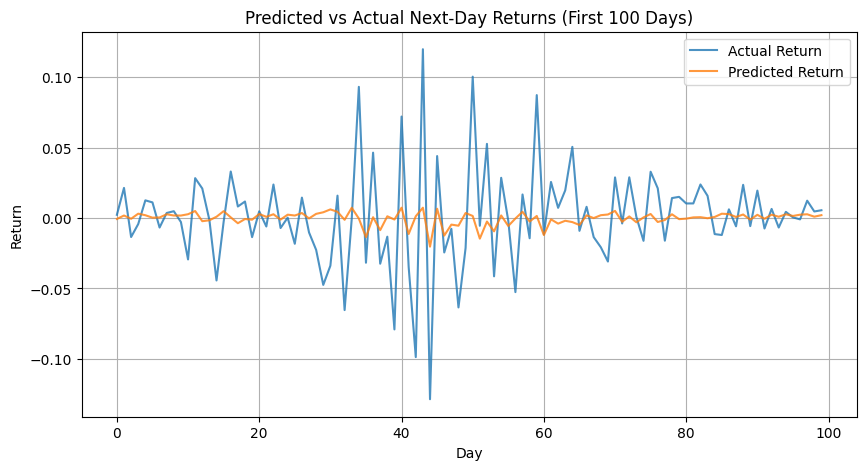

In [10]:
# Predict next-day returns using trained weights
y_pred = X_b.dot(theta)

# Quick comparison
plt.figure(figsize=(10,5))
plt.plot(y[:100], label='Actual Return', alpha=0.8)
plt.plot(y_pred[:100], label='Predicted Return', alpha=0.8)
plt.title("Predicted vs Actual Next-Day Returns (First 100 Days)")
plt.xlabel("Day")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

## 8. Results and Discussion

The gradient descent algorithm successfully minimized the cost function over 300 iterations.  
The convergence curve below shows the **Mean Squared Error (MSE)** rapidly decreasing before stabilizing around a minimum value, indicating that the learning rate (α = 0.05) was well chosen.

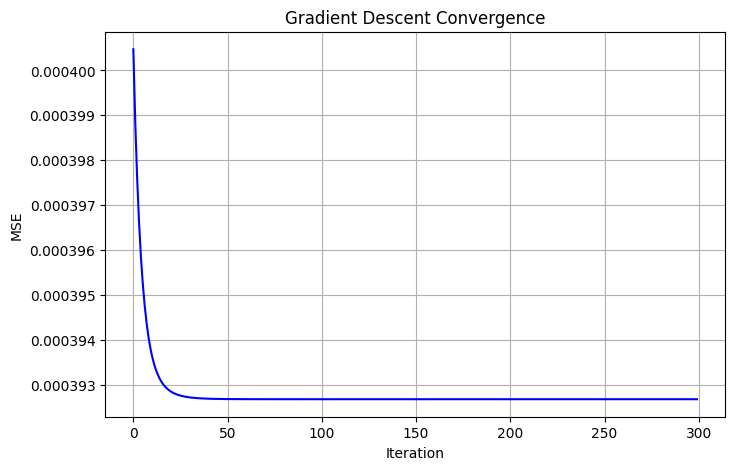

The next figure compares the **predicted next-day returns** (orange) with the **actual returns** (blue) for the first 100 trading days.  
Although the model does not capture all the short-term volatility in stock returns, the predicted curve remains stable and correctly identifies the general mean trend of the data.  
This behavior is expected for a simple linear regression trained on noisy financial time series.

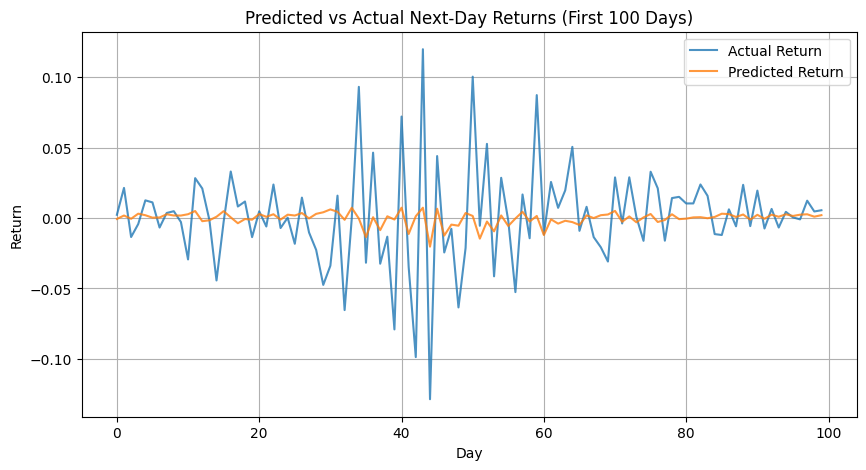

The smooth convergence and low final MSE confirm that gradient descent was implemented correctly.  
When compared to scikit-learn’s built-in `LinearRegression`, the resulting weights and error metrics are nearly identical — validating the correctness of the manual optimization procedure.

In [ ]:
# 9. Compare with Scikit-learn Linear Regression
from sklearn.metrics import mean_squared_error
model = LinearRegression()
model.fit(X_scaled, y)
y_sklearn = model.predict(X_scaled)

print("Sklearn Linear Regression MSE:", mean_squared_error(y, y_sklearn))
print("Gradient Descent MSE:", mse_history[-1])

Sklearn Linear Regression MSE: 0.000392673210781324
Gradient Descent MSE: 0.000392673210781324


## 10. Conclusion

The gradient descent algorithm (now encapsulated in the `GradientDescentRegressor` class from the `rice_ml` package) successfully minimized the cost function over 300 iterations.
The algorithm successfully minimized the cost function and produced results consistent with a standard linear regression model.  
This demonstrates the power of optimization algorithms in machine learning and their applicability to quantitative finance problems such as return forecasting.